## DIGITAL IMAGE PROCESSING IN THE SPATIAL-SPATIAL/FREQUENCY DOMAIN

#### APPLICATION OF THE WIGNER DISTRIBUTION TO IMAGE ANALYSIS THROUGH THE HISTOGRAMS OF SPATIAL FREQUENCY



**@author: Salvador Gabarda**

**salvador@optica.csic.es**

**This notebook includes Python functions for digital image processing based on the Wigner distribution.**

**Detailed information about this subject may be found in** 

https://www.osapublishing.org/josaa/abstract.cfm?uri=josaa-29-10-2058

https://www.researchgate.net/publication/321544037_Texture_classification_and_retrieval_through_space-frequency_histograms


*Created on Jan  2  2018, reviewed Dec 27 2019*




**Frequency histograms analysis based on the 1D local-directional Wigner distribution** 

A family of frequency histogram may be computed from the Wigner distribution. They can be used to build image features useful for e.g.: texture characterization. 

In [13]:
# import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.fftpack import fft, ifft
import math
from scipy import signal
import matplotlib.mlab as mlab
import pandas as pd
from scipy import special
import matplotlib.patches as mpatches


def oriented_pattern(seq_length,angle):
    """
    This function originates a pattern that it later used for the orientation
    of the operational pseudo-Wigner distribution window
    """
    angle = np.mod(angle,180)
    # correction to set axes in the image (x: rows, y: columns) to observer cartesian coordinates x,y
    angle = np.mod((angle+90),180)
    # conversion to radians
    angle =math.radians(angle)
    pi = math.pi
    h = int((seq_length/2))
    values = np.r_[float(-h):float(h+1)]
    new_positions = np.zeros([2*h+1, 2])
    for position in range(seq_length):
        if angle >= 0 and angle < pi/4:
            new_positions[position,0] = values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        elif angle >= pi/4 and angle < pi/2:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= pi/2 and angle < 3*pi/4:
            new_positions[position,0] = values[position]*math.tan(pi/2-angle)+h
            new_positions[position,1] = values[position]+h
        elif angle >= 3*pi/4 and angle <= pi:
            new_positions[position,0] = 1*values[position]+h
            new_positions[position,1] = values[position]*math.tan(angle)+h
        new_points = np.round_(new_positions)
    return new_points.astype(int)

def image_arrangement (test_image,seq_length,angle,indices):
    rows = test_image.shape[0]
    columns = test_image.shape[1]
    layers = np.zeros(((seq_length,rows,columns)))
    for k in range(seq_length):
        mask = np.zeros((seq_length,seq_length))
        mask[indices[k,0],indices[k,1]] = 1 
        #print(mask)
        layers[k,:,:] = signal.convolve2d(test_image, mask, boundary='symm', mode='same')
    return layers

def layer_product_function(layers,seq_length):
    faces = layers.shape[0]
    rows =layers.shape[1]
    columns = layers.shape[2]
    layer_product = np.ones(((seq_length-1,rows,columns)))
    layers[faces-1,:,:]=layers[0,:,:]
    for i in range(faces-1):
        layer_product[i,:,:]= layers[i,:,:]*layers[faces-1-i]
    return layer_product

def layer_wigner_distribution(test_image,seq_length,angle):
    indices = oriented_pattern(seq_length,angle)
    layers = image_arrangement (test_image,seq_length,angle,indices)
    layer_product = layer_product_function(layers,seq_length)
    distribution = fft(layer_product, axis = 0)
    distribution = np.real(distribution)
    # set zero frequency in central position
    Head = distribution[int(seq_length/2):seq_length,:,:]
    Tail = distribution[0:int(seq_length/2),:,:]
    distribution = np.append(Head,Tail, axis = 0)
    return distribution

def renyi_entropy(distribution,order):
    """
    This function calculates the Rényi entropy of an image based on its 
    pseudo-Wigner distribution (distribution). The variabe order represents
    the exponential order of the Rényi entropy (3 is the most common value)
    """
    eps = np.finfo(float).eps
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    squared_wl = np.ones([layers,rows,columns])
    for layer in range(layers):
        # square distribution local values
        working_layer = distribution[layer,:,:]
        squared_wl[layer,:,:] = np.multiply(working_layer,working_layer)
    squared_wd = squared_wl
    # sum squared wigner distribution along coordinate 0
    sum_sq_wd = np.sum(squared_wd, axis = 0)
    # normalize squared values
    normalized_distribution =np.zeros([layers,rows,columns])
    for layer in range(layers):
        normalized_distribution[layer,:,:] = np.divide(squared_wd[layer,:,:],sum_sq_wd+eps)
    # raise elements to the power defined by input variable "order"
    power_nor_dis = np.power(normalized_distribution,order)
    # sum pixelwise
    entropy_1 = np.sum(power_nor_dis, axis = 0)+eps
    # pixelwise entropy
    entropy_2 =np.log2(entropy_1)
    entropy =(1/(1-order))*entropy_2
    super_threshold_indices = entropy < 0
    entropy[super_threshold_indices] = 0
    entropy = np.nan_to_num(entropy)
    # normalize entropy
    #entropy = entropy*(1/np.log2(layers))
    return entropy

def show_wigner_frequencies(distribution):
    """
    Starting from the pseudo-Wigner distribution (distribution) of the
    input test image, this function gives a visualization of the frequency
    components of such distribution and images are saved in pdf's
    """
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    frequencies = np.zeros([layers,rows,columns])
    for layer in range(layers):
        frequency = distribution[layer,:,:]
        min_val =np.amin(frequency)
        frequency = frequency - min_val
        max_val = np.amax(frequency)
        frequency = (1/max_val)*frequency
        plt.figure()
        frequency = np.uint8(255*frequency)
        plt.imshow(frequency,cmap='gray')
        name = "wigner_distribution_" + str(layer) + ".pdf"
        msg = "Wigner distribution, frequency #" + str(layer)
        plt.xlabel(msg)
        plt.savefig(name)
        frequencies[layer,:,:]= frequency
    return frequencies 


def wigner_frequencies(distribution):
    """
    Starting from the pseudo-Wigner distribution (distribution) of the
    input test image, this function gives a visualization of the frequency
    components of such distribution and images are saved in pdf's
    """
    rows = distribution.shape[1]
    columns = distribution.shape[2]
    layers = distribution.shape[0]
    frequencies = np.zeros([layers,rows,columns])
    for layer in range(layers):
        frequency = distribution[layer,:,:]
        min_val =np.amin(frequency)
        frequency = frequency - min_val
        max_val = np.amax(frequency)
        frequency = (1/max_val)*frequency
        frequency = np.uint8(255*frequency)
        frequencies[layer,:,:]= frequency
    return frequencies 


def layer_image_anisotropy(test_image,seq_length,orientations,order):
    """
    This function calculates a parameter that has been considered as a
    measure of the spatial anisotropy of the image, based on the image content
    of the pseudo-Wigner distribution. It has been shown to be a good 
    objective index for the quality assessment of images in the cases of
    Gaussian blur and Gaussian noise
    """
    entropy_val = np.zeros([orientations])
    for orientation in range(orientations):
        angle = (180/orientations)*orientation
        print( angle, " degrees distribution")
        distribution = layer_wigner_distribution(test_image,seq_length,angle)
        entropy_pixelwise = renyi_entropy(distribution,order)
        entropy = np.mean(entropy_pixelwise)
        print("entropy is %.4f" % entropy)
        entropy_val[orientation] = entropy
    anisotropy = np.var(entropy_val)
    anisotropy = math.sqrt(anisotropy)
    print("\n")
    print("The AQI (image anisotropy) is %.4f" % anisotropy)
    print("\n")
    F = open("AQI test.txt","a")
    F.write(image_name)
    F.write("\n")
    F.write("The Anisotropic Quality Index of the image is %.4f\n" % anisotropy)
    F.close()
    return anisotropy

def plot_frequencies(frequencies,angle,entropy):
    layers = frequencies.shape[0]
    rows = frequencies.shape[1]
    columns = frequencies.shape[2]
    total = rows*columns
    num_bins = 256
    x =np.zeros((layers,total))

    plt.figure(figsize = (10,5))
    for k in range(limit):
        layer = np.copy(frequencies[k,:,:])
        x[k,:] = np.reshape(layer,total)
        plt.hist(x[k,:],num_bins,normed = True)
        lema = 'freq. hist. of the image, '+'angle = '+ str(angle) + ', entropy =  %.4f ' % entropy
        
    plt.title(lema)

  


**Test image** 

We input a test image for analysis ...


In [14]:
import os
os.path
cwd = os.getcwd()
print(cwd) 

/home/nbuser/library


In [15]:
def input_test_image(subfolder,name):
    total_name = subfolder + name
    input_image = mpimg.imread(total_name) 
    image_dimension = len(input_image.shape)
    if image_dimension == 3:
        test_image = (1/3)*(input_image[:,:,0]+
                      input_image[:,:,1]+input_image[:,:,2])
    else:
        test_image = input_image
    
    # convert image to regular gray levels 
    test_image =np.uint8(255*test_image)
    return test_image


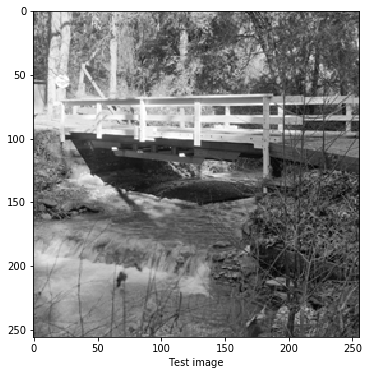

In [16]:
%matplotlib inline
# input test image
image_name = 'walkbridge.png'
subfolder = ''
test_image = input_test_image(subfolder,image_name)
# show image version to be processed 
plt.figure(figsize =(6,6))
plt.imshow(test_image, cmap='gray')
plt.xlabel("Test image")
plt.show()

**Wigner distribution** 

... and we calculate its 1-D pseudo-Wigner distribution as explained in 

S. Gabarda, G. Cristóbal, *"Blind image quality assessment through anisotropy"*, JOSA A, 2007


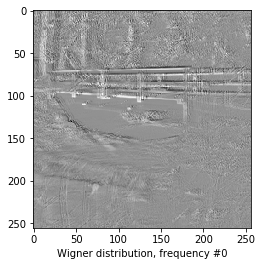

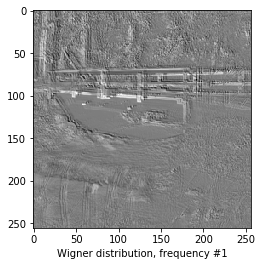

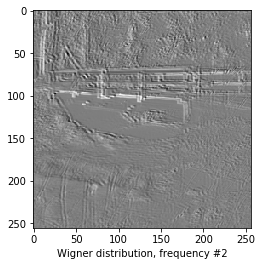

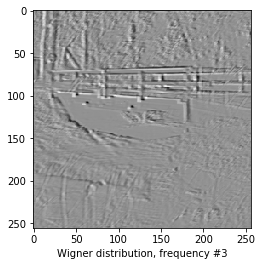

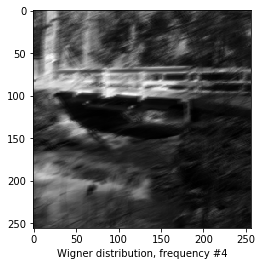

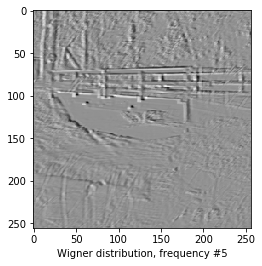

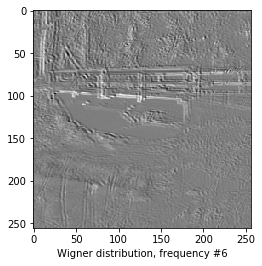

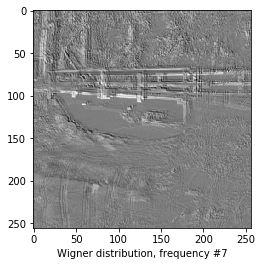

In [17]:
# calculate Wigner distribution of test image
seq_length = 9
angle = 22.5
distribution = layer_wigner_distribution(test_image,seq_length,angle)
# show distribution as a set of images
frequencies = show_wigner_frequencies(distribution)

**The histogram of image frequencies** 

When spatial frequency values are re-scaled to values in the range 0 to 255, they can be represented as images as shown above. They may be used to  build histograms of such frequencies. Histograms can be shown as below.

In [18]:
layers = frequencies.shape[0]
rows = frequencies.shape[1]
columns = frequencies.shape[2]
total = rows*columns
num_bins = 256
# the second half of the histograms are removed due to symmetry
limit = int(layers/2+1)
histogram = np.zeros((limit,num_bins))
for k in range(limit):
    layer = np.copy(frequencies[k,:,:])
    x = np.reshape(layer,total)
    H = np.histogram(x,bins = num_bins)
    histogramx = np.copy(H[0])
    histogram[k,:] = histogramx
    positions = np.copy(H[1])
    

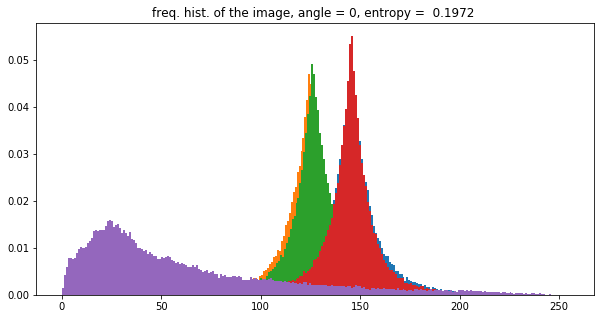

In [19]:
angle = 0
# entropy
order = 3
entropy_pixelwise = renyi_entropy(distribution,order)
entropy = np.mean(entropy_pixelwise)
plot_frequencies(frequencies,angle,entropy)

**Data** 

The frequency histograms can be stored as a single line of code for future analysis

In [20]:
histograms = histogram[1,:]
for k in range(1,limit):
    u = np.copy(histogram[k,:])
    histograms = np.append(histograms, u)


**Multi-directional analysis** 

Considering the set of $N$ discrete frequencies used to calculate the PWD of the image, we get a set of $N$ frequency histograms 

In [21]:
def multi_histogram_multy_entropy(times,origin,test_image,seq_length):
    for k in range(times):
        # calculate Wigner distribution of test image
        seq_length = 9
        angle = k*(180/times) + origin
        angle_str = str(k)
        distribution = layer_wigner_distribution(test_image,seq_length,angle)
        # set zero frequency in central position
        H = distribution[int(seq_length/2):seq_length,:,:]
        T = distribution[0:int(seq_length/2),:,:]
        distribution = np.append(H,T, axis = 0)
        # entropy
        order = 3
        entropy_pixelwise = renyi_entropy(distribution,order)
        entropy = np.mean(entropy_pixelwise)
        if k == 0:
            multi_entropy = np.copy(entropy)
        else:
            multi_entropy = np.append(multi_entropy,np.copy(entropy))
        msg = 'angle = ' + str(angle)
        #print(msg)
        #print("entropy is %.4f" % entropy)
        # show distribution as a set of images
        frequencies = wigner_frequencies(distribution)
        layers = frequencies.shape[0]
        rows = frequencies.shape[1]
        columns = frequencies.shape[2]
        total = rows*columns
        num_bins = 256
        # the second half of the histograms are removed due to symmetry
        limit = int(layers/2+1)
        histogram = np.zeros((limit,num_bins))
        for k2 in range(limit):
            layer = np.copy(frequencies[k2,:,:])
            x = np.reshape(layer,total)
            H = np.histogram(x,bins = num_bins)
            histogramx = np.copy(H[0])
            histogram[k2,:] = histogramx
            positions = np.copy(H[1])
            layers = frequencies.shape[0]
        rows = frequencies.shape[1]
        columns = frequencies.shape[2]
        total = rows*columns
        num_bins = 256
        x =np.zeros((layers,total))
        plot_frequencies(frequencies,angle,entropy)
   
    
        histograms = histogram[1,:]
        for k3 in range(1,limit):
            u = np.copy(histogram[k3,:])
            histograms = np.append(histograms, u)
        data = {angle_str: histograms}
        df1 = pd.DataFrame(data)
        if k == 0:
            multi_data = df1
        else:
            multi_data[angle_str] = df1
    return multi_data, multi_entropy


def multi_entropy(times,origin,test_image,seq_length):
    for k in range(times):
        # calculate Wigner distribution of test image
        seq_length = 9
        angle = k*(180/times) + origin
        angle_str = str(k)
        distribution = layer_wigner_distribution(test_image,seq_length,angle)
        # set zero frequency in central position
        H = distribution[int(seq_length/2):seq_length,:,:]
        T = distribution[0:int(seq_length/2),:,:]
        distribution = np.append(H,T, axis = 0)
        # entropy
        order = 3
        entropy_pixelwise = renyi_entropy(distribution,order)
        entropy = np.mean(entropy_pixelwise)
        if k == 0:
            multi_entropy = np.copy(entropy)
        else:
            multi_entropy = np.append(multi_entropy,np.copy(entropy))
        super_threshold_indices = multi_entropy < 0
        multi_entropy[super_threshold_indices] = 0
        
    return multi_entropy
    
        
 

**Number of directions** 

For different orientations we obtain different frequency histograms and different values of entropy. However, for the directional features in the image to be comparable it is required that the number of pixels per unit of length be equal. When working with square windows, this is only possible when using the angles $\pi / 8$,$3 \pi / 8$, $5 \pi / 8$ , $7 \pi / 8$ (in degrees 22.5, 67.5, 112.5 and 157.5). The remaining directions in between have to be estimated by an appropriate distribution, e.g., the von Mises distribution.

In [22]:
seq_length = 9
angle = 0
distribution = layer_wigner_distribution(test_image,seq_length,angle)
entropy_pixelwise = renyi_entropy(distribution,order)

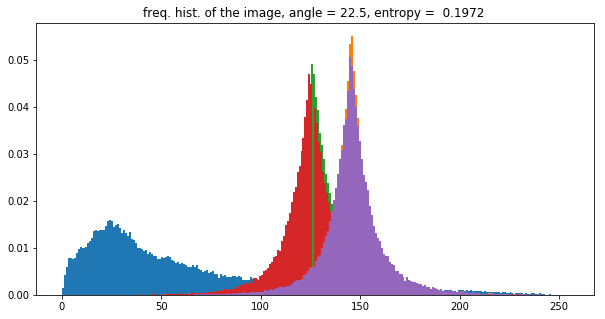

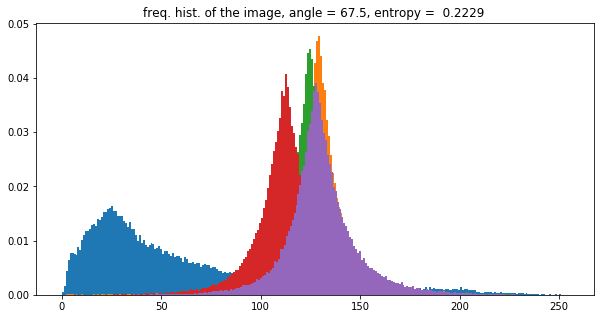

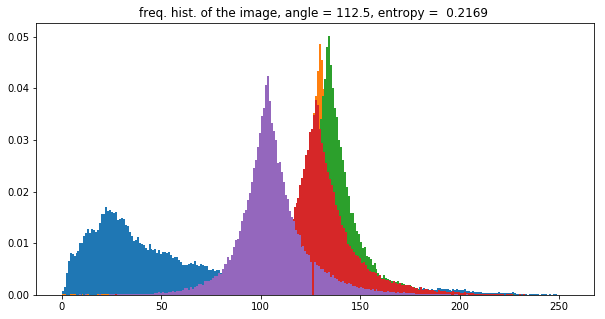

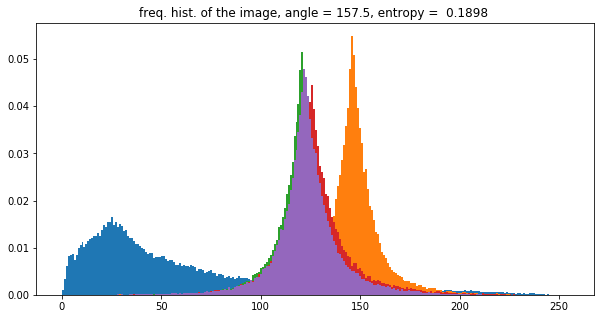

In [23]:
times = 4
origin = 22.5
multi_data,multi_entropy = multi_histogram_multy_entropy(times,origin,test_image,seq_length)

**Data** 

The above data has been also stored in a dataframe as follows

In [24]:
pd.options.display.max_rows = 14
multi_data



0    1    2    3
0     1.0  1.0  5.0  1.0
1     0.0  1.0  5.0  0.0
2     0.0  8.0  2.0  0.0
3     0.0  7.0  1.0  0.0
4     0.0  4.0  5.0  1.0
5     0.0  5.0  6.0  1.0
6     0.0  1.0  5.0  0.0
...   ...  ...  ...  ...
1273  0.0  0.0  0.0  0.0
1274  1.0  0.0  0.0  0.0
1275  0.0  0.0  0.0  0.0
1276  0.0  0.0  0.0  0.0
1277  1.0  0.0  0.0  0.0
1278  0.0  0.0  0.0  0.0
1279  1.0  1.0  1.0  1.0

[1280 rows x 4 columns]